# 5TF078 Deep Learning Course
## Excercise 1 Convolutional Neural Networks on Fashion-MNIST
Created by Tomas Nordström, Umeå University

Revisions:
* 2022-03-23 First revision based on earlier excercises /ToNo
* 2022-03-30 Adjusted the Keras Tuner search to reduce compute times. /Tomas
* 2022-04-05 Added padding='same' as an argument to Conv2D. /Tomas
* 2022-05-09 Swaped optimizer to use 'adam' as default and 'sgd' as extra test. /Tomas
* 2022-05-09 Fixed so that we can use the latest version (1.1.2) of keras tuner. /Tomas
* 2022-11-07 Added hints to use incremental model definitions when we want to have varying number of layers with Keras tuner. /Tomas
* 2022-11-09 Updated check for colab to NOT use env. var. COLAB_GPU as it has gone missing. /Tomas

## **Glöm inte ditt namn!**

# First we initilize our Python environment

In [ ]:
# Import needed libraries
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

from tensorflow import keras
# from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Dropout, \
                         MaxPooling2D, Input, Activation, Add
from keras.utils  import to_categorical
from keras.models import Model, Sequential
print('Keras version:',tf.keras.__version__)
# Helper libraries
import numpy as np
import sklearn
from   sklearn.model_selection import train_test_split

# Matlab plotting
import matplotlib
import matplotlib.pyplot as plt

# Typing imports for type hints / readability
from typing import Tuple, List, Dict, Any, Union
init = True

TensorFlow version: 2.8.0
Keras version: 2.8.0


In [ ]:
# Test for GPU and determine what GPU we have
import sys
if not tf.config.list_physical_devices('GPU'):
     print("No GPU was detected. CNNs can be very slow without a GPU.")
     IN_COLAB = 'google.colab' in sys.modules
     if IN_COLAB:
         print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
else:
     !nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3090 (UUID: GPU-56d64c0c-e161-9720-5e6d-9848f27424d1)


2022-05-09 17:39:26.472589: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 17:39:26.492555: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 17:39:26.492656: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# Set up the needed data sets

## Get hold of a data-set
In this exercise we will use Fashion MNIST dataset, which an alternative to MNIST (it is a little harder, but the image size is the same). This is available directly as a [Keras dataset](https://keras.io/datasets/). This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images. 

Note that we split our data into **three** data sets: training, validation, testing; each with its own purpose.

In [ ]:
# Get Fashion-MNIST training and test data from Keras database (https://keras.io/datasets/)
(train_images0, train_labels0), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Define labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Split the training set into a training and a validation set (20% is validation)
train_images, val_images, train_labels, val_labels = train_test_split(train_images0, train_labels0, test_size=0.20)

In [ ]:
# Print som basic information of data set sizes and data sizes
train_no,x,y = train_images.shape
print('No training images:',train_no, ' with image size:',x,'x',y)
label_no = len(train_labels)
if (label_no != train_no) : 
  print('# labels do not match # training images')

test_no,x,y = test_images.shape
label_no = len(test_labels)
print('No test images:',test_no)
if (label_no != test_no) : 
  print('# labels do not match # test images')

val_no,x,y = val_images.shape
label_no = len(val_labels)
print('No val images:',val_no)
if (label_no != val_no) : 
  print('# labels do not match # val images')

classes = np.unique(train_labels)
num_classes = len(classes)
print('Training labels:', np.unique(train_labels), "; That is,", num_classes,"classes." )


No training images: 48000  with image size: 28 x 28
No test images: 10000
No val images: 12000
Training labels: [0 1 2 3 4 5 6 7 8 9] ; That is, 10 classes.


Note that the training labels are an integer between 0 and 9, which is not very good as outputs (or inputs) for DL models. A better approach would be to use a one-hot encoding. We can convert our label vectors to one-hot encoded matrices by using [to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) `tf.keras.utils.to_categorical(train_labels)`.

But we can achieve the same thing by using [SparseCategoricalCrossentropy](https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class) as a loss function instead of the [CategoricalCrossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class). Also note that in both cases we need our model to have as many output nodes as we have classes! 

## Adjust the data to be better work as ML input

Many models working with images are assuming the data to be represented as a 4-D tensor with the shape BHWC [batch_size, height, width, channels] (some ML frameworks prefer to use BCHW instead, so be careful when starting to work on new datasets or ML-frameworks).

We also want to normalize data to be "small" and "close" to zero, e.g. 0 to 1 or –1 to 1. In this example we normalize to values between –0.5 and 0.5.

In [ ]:
# Add an "empty" color dimension for our data sets
def pre_process():
    train_images = np.expand_dims(train_images, -1)
    val_images = np.expand_dims(val_images, -1)
    test_images = np.expand_dims(test_images, -1)

    # Normalize the images.
    train_images = (train_images / 255) - 0.5
    test_images = (test_images / 255) - 0.5
    val_images = (val_images / 255) - 0.5
if init:
    pre_process()
    init = not init

## Explore the data
It is always advised to take a look at the data, to see if we need to massage it further.

Label: Pullover


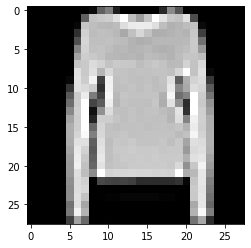

Label: Sandal


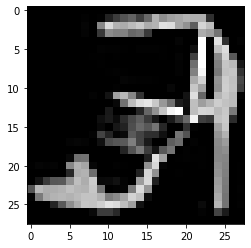

In [ ]:
# As these are images (28x28) it can be interesting to plot some as images

image_index = [42, 789] # "Random" images to print
str2data = {
  "train": (train_images, train_labels),
  "val": (val_images, val_labels),
  "test": (test_images, test_labels)
}
def plot_sample(index:List[int], data:str="train"):
  images, labels = str2data[data]
  for index in image_index:
    print( 'Label:', class_names[train_labels[index]])
    plt.figure()
    plt.imshow(np.squeeze(train_images[index], axis=-1))
    plt.gray()
    plt.grid(False)
    plt.show(block=False)
plot_sample(image_index)

# Define a convolutional network model

## Define the model using Keras

Note that this is a *very* small modell just to have a strating point. A good modell is expected to have 5-50 times as many parameters!

In [ ]:
# We need to give the input shape (i.e. our image shape) to our model
input_shape = test_images[0].shape
print("Input shape", input_shape)

# The Keras model will be the simplest Keras model for NN networks. 
# It is a single stack of layers connected sequentially.
def simple_model()->Sequential:
    model = Sequential([

    # Add a convolution layer
    Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),

    # Flatten the input. This prepares the vector for fully connected layers.
    Flatten(),

    # Add a hidden Dense layer
    Dense(units=16, activation='relu'),

    # Add a an output layer. The output space is the number of classes
    #    Softmax makes the output as probablity vector of the different classes
    Dense(units=num_classes, activation='softmax')

    ])
    print("Simple Model")
    print(model.summary())
    return model
def resnet_model()->Model:
    inp = Input(shape=input_shape)
    ## TODO: Add your ResNet model here
    return None

model = simple_model()

Input shape (28, 28, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 16)                200720    
                                                                 
 dense_1 (Dense)             (None, 10)                170       
                                                                 
Total params: 201,050
Trainable params: 201,050
Non-trainable params: 0
_________________________________________________________________


2022-05-09 17:39:27.112908: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-09 17:39:27.114264: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 17:39:27.114455: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 17:39:27.114551: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

# Set up the model and optimizer for training
To set up the optimization of this model we need to compile it, and set what [optimizer](https://keras.io/api/optimizers/), what [loss](https://keras.io/api/losses/), and what [metrics](https://keras.io/api/metrics/) to use. Where, metric is similar to a loss but not used during training but can be used to measure training progress.

The model (its parameters) is also initialized to some random values during this phase.

In [ ]:
# Compile the model, as a preparation for training
def compile_model(model:Model,loss:Union[keras.losses.Loss, str],metrics:List)->Model:
  model.compile(
    optimizer='adam',
    loss=loss,
    metrics=metrics
  )
  return model
model = compile_model(model, 'categorical_crossentropy', ['categorical_accuracy'])

# Run the training

In [ ]:
epochs = 15      ## Number of epoch to run
batch_size = 32  ## Mini batch size
def train_model(model:Model, epochs:int, batch_size:int)->keras.callbacks.History:
  # Train the model.
  history = model.fit(
    train_images, to_categorical(train_labels),
    epochs=epochs,
    batch_size=batch_size,
    verbose = 1,
    validation_data=(val_images, to_categorical(val_labels))
  )
  return history
history = train_model(simple_model(), epochs, batch_size)

Epoch 1/15


2022-05-09 17:39:28.412941: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400


  45/1500 [..............................] - ETA: 1s - loss: 1.4234 - categorical_accuracy: 0.5236   

2022-05-09 17:39:29.156084: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1500/1500 [==============================] - 4s 1ms/step - loss: 0.4799 - categorical_accuracy: 0.8330 - val_loss: 0.3719 - val_categorical_accuracy: 0.8681
Epoch 2/15
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3185 - categorical_accuracy: 0.8860 - val_loss: 0.3235 - val_categorical_accuracy: 0.8866
Epoch 3/15
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2769 - categorical_accuracy: 0.9003 - val_loss: 0.3047 - val_categorical_accuracy: 0.8942
Epoch 4/15
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2500 - categorical_accuracy: 0.9096 - val_loss: 0.3316 - val_categorical_accuracy: 0.8826
Epoch 5/15
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2286 - categorical_accuracy: 0.9176 - val_loss: 0.3110 - val_categorical_accuracy: 0.8889
Epoch 6/15
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2094 - categorical_accuracy: 0.9242 - val_loss: 0.2945 - val_categorical_accuracy: 0.8977
Epo

# Explore the training progress
Show the training progress, by plotting the training and validation accuracy and loss

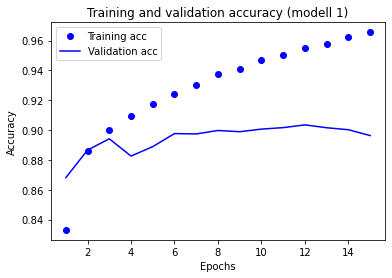

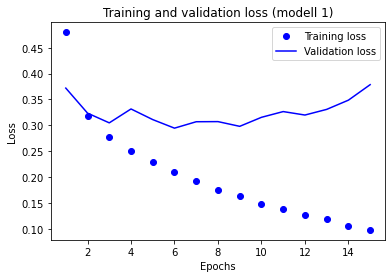

In [ ]:
def plot_history(history:keras.callbacks.History, epochs:int):
    epochrange = range(1, epochs + 1)
    train_acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.plot(epochrange, train_acc, 'bo', label='Training acc')
    plt.plot(epochrange, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy (modell 1)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(epochrange, train_loss, 'bo', label='Training loss')
    plt.plot(epochrange, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss (modell 1)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
plot_history(history, epochs)

Notera hur träningsnoggrannheten konstant går uppåt (och träningsförlusten nedåt). Medan valideringsförlusten bottnar ut någonstans mellan 5-10 epochs för att sedan långsamt går uppåt. Detta tyder på en svag överträning, om förlusten hade fortsatt nedåt tillsammans med träningsförlusten hade modellen fortfarande varit undertränad. Men överlag kan vi misstänka att modellens kapacitet vid 15 epochs är det bästa som denna modell kan åstadkomma.

# Evaluate the model on the test data.
This first model get something around 89.5 % accuracy, not bad, but we can improve on this!

In [ ]:
def eval(model:Model, data:str="test"):
    images, labels = str2data[data]
    # Evaluate the model.
    test_loss, test_acc = model.evaluate(images,to_categorical(labels))
    print('Test accuracy: %.3f' % test_acc)
    return test_acc

313/313 [==============================] - 0s 1ms/step - loss: 0.3863 - categorical_accuracy: 0.8958
Test accuracy: 0.896


# Övning Del 1a
## Frågor att besvara:
* Hur många parametrar har din modell?
* Vilken testnoggrannhet får du? (Då modellen är slumpmässing initierad kan du få ett värde som skiljer sig lite grann.)
* Om du tittar på träningsförloppet, har modellen tränat färdigt eller är den undertränad eller kanske övertränad, vad i träningskurvorna kan avgöra det?
* Hur många epochs skulle ha varit lämpligt att använda?

# Del 1b - Fortsatta experiment:
Det finns nu många saker du kan utforska men vi vill att du nu undersöker lite olika modeller. Undersök om du får en förbättring av testnoggrannhet ifall du gör modellen mer kraftfull (fler noder och/eller fler lager). Ha hela tiden ett öga på ifall modellen börjar överträna (att valideringsförlusten börjar gå uppåt igen). Notera att man gärna har med MaxPooling2D-lager mellan varje eller varannat faltningslager, då det hjälper med att hålla ner antalet parametrar vilket även leder till snabbare och ofta bättre träningsresultat (ger tex en viss extra translations och skalinvarians). Detta är speciellt viktigt om man har stora inbilder, men kan nog ge bra effekt även på våra minimala bilder.

Målet är att få modellen att bli komplex nog att väl kunna representera data. En viss överträning är OK, vi ska ju sedan åtgärda det med regularisering.
* Hur många faltningslager verkar rimligt att använda (håll dig under 4-5, det kan vara bättre att lägga till kärnor istället.
* Hur många kärnor/noder verkar vettigt att använda?
* Pröva även att använda ex 5x5 kärna för det första eller kanske något lager till, blir det bättre då? 
* Om en modell övertränar, gör ett experiment där du istället för att köra alla dina epochs slutar där verifieringsfelet börjar gå uppåt igen. Vad blir skillnaden i testnoggrannhet?

Du behöver inte ha med kod för alla experiment, om du inte vill, men vi vill åtminstone se koden, träningsförloppet, och testnoggrannheten för din bästa modell.

För minst en av dessa parameterinställningar ska du nå mer än 90% rätt på testdata för Fashion-MNIST.

In [ ]:
# Kod för din bästa modell och dess träning och utvärdering

## Analys
Dokumentera dina experiment, med modellkonfiguration, testnoggrannhet, och vid vilken epoch modellen börjar överträna.
* Gör en sammanfattande analys av dina experiment hittills.

# Övning Del 2a - avbruten träning
Utgå ifrån din bästa modell som du fått fram i del 1 och för den implementera avbruten träning (eng. early stopping) som ett sätt att förhindra överträning. [See Geron s. 141]

Du behöver definiera en "callback" som sedan includeras i anropet till model.fit: *es=tf.keras.callbacks.EarlyStopping('val_loss', patience=3, restore_best_weights = True)*

*model.fit(
  train_images, to_categorical(train_labels),
  epochs=epochs,
  batch_size=batch_size,
  **callbacks=[es]**,
  validation_data=(val_images, to_categorical(val_labels))
)*

Viktigt är att notera restore_best_weights=True ifall man använder patience>0, för annars så har man en övertränad modell efter träningen.


In [ ]:
# Kod där du inför avbruten träning

## Analys
Vid vilken Epoch stannar nu träningen? Ändras nu modellens testnoggrannhet då den inte övertränar?

# Övning Del 2b Andra former av regularisering


Utgå ifrån din bästa modell som du fått fram i del 1 men använd avbruten träning. Nu ska du skapa en modell som använder regularisering, tex. drop-out eller batchnormalisering. Analysera och jämför dessa modeller (med och utan regularisering) genom att notera deras testnoggrannhet och plotta tränings- och valideringsnoggrannheten (eng. accuracy) respektive förlust (eng. loss), och notera ifall en förbättring kan iakttas med regularisering. Hur många Epoch använder du för träningen? [See Geron s 338, s. 365]

In [ ]:
# Kod där du inför regularisering

## Analys
Analysera och jämför dina modeller (med och utan regularisering) genom att notera deras testnoggrannhet och plotta tränings- och valideringsnoggrannheten (eng. accuracy) respektive förlust (eng. loss), och notera ifall en förbättring kan iakttas med regularisering. Hur många Epoch använder du för träningen? 

# Övriga Hyperparametrar
Det finns ett antal andra viktiga parametrar som man kan behöva justera. Men flera av dem hänger ihop, så man behöver jobba med olika modeller och data för att få en bra känsla för dem. [See Geron s. 325.., s. 351.. ]
* Batch size / batch storlek -- Ett större värde här kan ge GPUn mer parallellism att arbeta med, dvs snabbare, men ett för stort värde kan ge minnesproblem i GPUn och dessutom göra inlärningen långsammare (man kan dock även ha större LR i så fall.
* Optimizer / optimerare -- En vanlig och bra optimerade är Adam (den är dessutom ganska okänslig för vilken inlärningstakt som den startar med, vilket gör att skönsvärdet fugerar bra). Medan sgd är en mer "ursprunglig" optimerare.
* Learning rate / inlärningstakt (LR) -- Viktig parameter för hur snabbt modellen tränar, men för stort färde kan ge instabil träning.

# Övning Del 2c
Byt ut optimeraren från adam till sgd (med regularisering och avbruten träning). Jämför träningsförfarandet mellan de två optimerarna (skillnad i testnoggrannhet, vilken epoch stannade träningen, etc.?). 

In [ ]:
# Din kod för en körning med sgd som optimerare

# Del 3 Auto tune
Here we test on of the hyperparameter optimizers called Keras Tuner. Documentation can be found here: https://keras-team.github.io/keras-tuner/

In [ ]:
# Get Keras Tuner (if in colab)
import sys
if 'google.colab' in sys.modules:
  !pip install keras_tuner -q

import keras_tuner
print('Keras Tuner version:', keras_tuner.__version__)

# Get some tuner search functions
from keras_tuner.tuners import BayesianOptimization

Keras Tuner version: 1.1.2


## Exempelmodell (du ska sedan göra en egen!)

In [ ]:
# This is a straight forward CNN model to decently solve Fashion MNIST
# Note that we have no regularisation for this example!
# It can at least achieve 92% accuracy for me, with the parameters found:
# conv_1_filter =  96, conv_1_kernel =   5, 
# conv_2_filter =  48, conv_2_kernel =   5
# dense_1_units =  128
# learning_rate = 0.001
# batch_size = 320

def build_model_2Conv1Dense(hp):  
  model = tf.keras.Sequential([
    # First Convolutional Layer
    tf.keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        padding='same',
        input_shape=(28,28,1)
    ),
    tf.keras.layers.BatchNormalization(),

    # Second Convolutional Layer
    tf.keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu',
        padding='same'
    ),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),

    # A First Dense Layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=256, step=32),
        activation='relu'
    ),

    # A Final Dense Layer
    tf.keras.layers.Dense(10, activation='softmax')
  ])
  
  model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

# Övning 3: Kod för instrumentera din egen model att optimeras med Keras Tuner
Utgå ifrån din bästa modell som du fått fram i del 2 och instrumentera den för att optimeras med Keras Tuner.

In [ ]:
# Kompletera denna kod med din modell
def build_model_MyModel(hp):  
  model = tf.keras.Sequential([
    # First Convolutional Layer5'
    ##### YOUR CODE HERE! #####

    # A Final Dense Layer
    tf.keras.layers.Dense(10, activation='softmax')
  ])
  
  ##### You can also try some other learning rates in the next line, or use another optimizer with other parameters
  model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

# Do the actual search, based on a BayesianOptimization
Widely-used tuning algorithms: RandomSearch, BayesianOptimization and Hyperband. Here we will use BayesianOptimization. 

But note that there is a parameter *num_initial_points* to BayesianOptimization which state the number of randomly generated samples as initial training data for Bayesian optimization. If left unspecified, a value of 3 times the dimensionality of the hyperparameter space is used. That is, we might only use random search if we have too few trails.

In [ ]:
# To get more stable results we are repeating the runs two times for each parameter setup
MAX_TRIALS = 20         # represents the number of hyperparameter combinations that will be tested by the tuner
EXECUTION_PER_TRIAL = 2 # the number of models that should be built and fit for each trial for robustness purposes

In [ ]:
# To have batch_size as a hyperparameter we need to define our own tuner
# In this case, we are basing it on the BayesianOptimization tuner found in
# https://keras-team.github.io/keras-tuner/documentation/tuners/#bayesianoptimization-class
class MyTuner(keras_tuner.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 512, step=32, default=256)
    return super(MyTuner, self).run_trial(trial, *args, **kwargs)

In [ ]:
# Bayesian search which also searches for batch_size
tuner = MyTuner(
    build_model_2Conv1Dense, ##### Laboration: Change this to 'build_model_MyModel' #####
    max_trials=MAX_TRIALS,
    objective='val_accuracy',
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='output',
    overwrite=True,
    num_initial_points=10, # Start with 10 random points and then do more structured search
    project_name='FashionMNIST'
)

# Help it takes so much time!
Yes, doing a parameter search takes time! Using a K80 this search takes 1h24 (while a RTX 3090 takes 10 minutes), and if your model is more complicated it can take even more time. To handle this you could try setting EXECUTION_PER_TRIAL=1, even if the search becomes more instable. You can also try to run in phases, do a first run with EXECUTION_PER_TRIAL=1 and even noepochauto = 4 or 5, to get a feeling for good parameter limits and starting points (setting things like "default=128" in the hp.Int() call) for your variables, and maybe even lock some variables (like LR?). And then do a more focused search where you maybe try EXECUTION_PER_TRIAL=2, noepochauto = 6 or 7 for a smaller number of MAX_TRIALS.

If you do such multiphase process, please document it well!

In [ ]:
# Do the hyperparameter search
# I set the no of epochs to 6 to speed up the search in this excersise, better would have been 10
noepochauto = 6   ## Max number of epochs per trail (but we have early stopping so this max is probably not reached)
es = tf.keras.callbacks.EarlyStopping('val_loss', patience=2, restore_best_weights = True)
# Note we do not need to_catagorical as we use loss='sparse_categorical_crossentropy'
tuner.search(train_images, train_labels, 
             epochs=noepochauto, 
             validation_data=(val_images, val_labels), 
             callbacks=[es])

Trial 20 Complete [00h 00m 25s]
val_accuracy: 0.8767916858196259

Best val_accuracy So Far: 0.9229583144187927
Total elapsed time: 00h 14m 24s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get the best model so far
model = tuner.get_best_models(num_models=1)[0]
# Dump the best hyperparameters found
vals = tuner.get_best_hyperparameters(num_trials=5)[4].values
for keys,values in vals.items():
    print('%20s = %3.4g' %(keys,values))
    
model.summary()

       conv_1_filter = 224
       conv_1_kernel =   5
       conv_2_filter = 160
       conv_2_kernel =   5
       dense_1_units = 128
       learning_rate = 0.001
          batch_size = 384
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 256)       2560      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 256)      1024      
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 256)       590080    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 256)      0         
 )                                                               
                                                               

In [ ]:
# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,test_labels)
print('Test accuracy: %.3f' % test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.2340 - accuracy: 0.9221
Test accuracy: 0.922


## Code to explore the n-best models

In [ ]:
# Let us dump the n-best

if True:
  explorenbest = 5

  # Suppress warnings about optimizer state not being restored by tf.keras.
  tf.get_logger().setLevel('ERROR')

  # Print a heading
  vals = tuner.get_best_hyperparameters(num_trials=explorenbest)[0].values
  print('Test accuracy ', end = '')
  for keys,values in vals.items():
      print('%15s ' %(keys), end = '')
  print('\n')

  # Now print each trail on a seperate row from best to worst
  for ix in range(0,explorenbest): 
    # evaluate this trail
    model = tuner.get_best_models(num_models=explorenbest)[ix]
    test_loss, test_acc = model.evaluate(test_images,test_labels, verbose=0)
    print('%15.3f ' % test_acc , end = '')
    # get this trail's hyperparameters
    vals = tuner.get_best_hyperparameters(num_trials=explorenbest)[ix].values
    for keys,values in vals.items():
      print('%15.4g ' %(values), end = '')
    # end this line and start the trail
    print()

Test accuracy   conv_1_filter   conv_1_kernel   conv_2_filter   conv_2_kernel   dense_1_units   learning_rate      batch_size 

          0.922             256               3             256               3              96           0.001             320 
          0.913             160               3             256               3             256           0.001              32 
          0.909             160               3             160               5              64           0.001             128 
          0.907              32               5              32               5             256           0.001              32 
          0.912             224               5             160               5             128           0.001             384 


Notice that the model with the best validation accuracy not necessarily gives the best test accuracy! But we have to live with this as this is the best we can do with the data set aside for training and validation. 

# With our found hyperparameters, continue training
(We do this especially as we only done 6 epochs during search.)

In [ ]:
# Fine-tune the model using the best parameters found as we might not be fully trained
model = tuner.get_best_models(num_models=1)[0]

epochs = 30      ## (max) number of epoch to run
opt_batch_size = tuner.get_best_hyperparameters()[0]['batch_size']

# Set callback functions to early stop training
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=2, restore_best_weights = True)]

# Continue to train the model. (note that we are continuing from the training done during tuning)
history = model.fit(
  train_images, train_labels,
  epochs=epochs,
  batch_size=opt_batch_size,
  verbose = 1,
  validation_data=(val_images, val_labels),
  # initial_epoch=noepochauto, ## how to get this number???? from... "(root).optimizer.iter" maybe
  callbacks=callbacks
)

Epoch 1/30
150/150 [==============================] - 5s 33ms/step - loss: 0.1083 - accuracy: 0.9617 - val_loss: 0.2441 - val_accuracy: 0.9157
Epoch 2/30
150/150 [==============================] - 5s 33ms/step - loss: 0.0818 - accuracy: 0.9707 - val_loss: 0.2697 - val_accuracy: 0.9184
Epoch 3/30
150/150 [==============================] - 5s 33ms/step - loss: 0.0662 - accuracy: 0.9762 - val_loss: 0.2746 - val_accuracy: 0.9196
Epoch 3: early stopping


In [ ]:
# Evaluate the model.
test_loss, test_acc = model.evaluate(test_images,test_labels)
print('Test accuracy: %.3f' % test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.2534 - accuracy: 0.9160
Test accuracy: 0.916


In [ ]:
# See what we got and how many parameters are used
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 256)       2560      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 256)      1024      
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 256)       590080    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 256)      0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 96)                4

#Analys
Gör en komplett analys av de optimerade modellerna du fått fram mha Keras Tuner. Några frågor man kan ställa sig:
* Hur jämför sig dessa värden, mha en Bayesiansk sökning, från de värden då fått fram i del 1 och del 2? 
* Vilka prestanda fick du för de olika fallen? 
* Finns det parametrar som ligger vid ändvärdena av den använda sökrymden? (i så fall kanske du borde köra om med utökade gränser?)
* Vilka hyperparametrar verkade vara mest betydelsefulla? 
* Kan man se någon trend bland parametrarna (tex antalet faltningskärnor i tidiga respektive sena lager, etc)? 
* Varför utför man samma experiment flera gångar "EXECUTION_PER_TRIAL = 2", dvs varför blir det inte samma resultat varje gång?
* Annat som du iaktagit?

# Uppgifter för väl godkänt

Utökning av Del2: Utforska de testfall som missklassificerades för en av dina toppmodeller, vilka typer av plagg verkar vara de som oftast blir fel på, om du tittar på dessa fel förstår du varför nätet har problem med dem?

In [ ]:
# Din kod som utforskar de testfall som missklassificerades

Utökning av Del3: Implementera en undersökning där du även varierar antal lager i din modell, du kan ändra både faltningslager och kompakta lager (eng. dense layers) för att se ifall en ännu bättre modell kan hittas.

Tips: Det är nog bäst att använda en inkrementell/funktionell definition av modellen (där lager läggs till med "model.add(...)" för då blir det lättare att göra en for-slinga runt koden som lägger till ett visst antal lager. Jmf https://keras.io/guides/sequential_model/ 


```
    filter1=hp.Int('conv_pre_filter', min_value=32, max_value=160, step=32, default=64)
    kernel1=hp.Choice('conv_pre_kernel', values = [3,5], default=3)
    model = Sequential()
    # Add a first convolution layer (with input size)
    model.add(Conv2D(filters=filter1, kernel_size=kernel1, padding='same', activation='relu', input_shape=train_images[0].shape))
    # More fixed layers?
    model.add(....more layer definitions....) 
    # Add a varying number of layers
    no_layers = hp.Int('num_layers', 0, 3)
    for i in range(no_layers):
          model.add(Conv2D(filters=hp.Int(f'conv_{i+1}_units', ...parameters...), 
                          kernel_size=hp.Choice(f'conv_{i+1}_kernel', ...parameters....),
                          activation='relu'
                          )
                    )

```



In [ ]:
# Din kod för en keras tuner modell som har antalet lager som en hyperparameter 
# och där du söker efter optimerade hyperparametrar för denna modell.